## Importing and initializing basic libraries for processing and plotting
## jupyter notebook has lot of inbuilt libraries if any module is missing, we can use 
## 'pip install' to install them

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, for csv,text etc files....


import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
#nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize


## Setting the input folder and reading the filenames 
## spam filenames refer to the dataset which is taken as spam mails
## ham filenames refer to the datset which we have to classify 

In [2]:
spam_folder =r'F:\python_spam\flask_app\dataset\spam'
ham_folder =r'F:\python_spam\flask_app\dataset\ham'

ham_filenames = [name for name in sorted(os.listdir(ham_folder)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(spam_folder)) if len(name) > 20]


## Gaining certain insights from data

In [3]:
print('Number of non-spam samples:', len(ham_filenames))
print('Number of spam samples:', len(spam_filenames))
print('Ratio of non-spam to spam samples:', len(ham_filenames)/len(spam_filenames))

Number of non-spam samples: 3672
Number of spam samples: 1500
Ratio of non-spam to spam samples: 2.448


## Loading of  data
##  For this we used the email package which is  specially designed in managing email        messages
##  Mainly using its policy components which not only allows email message to be parsed using parser, but to serialize it using standard SMTP settings.

In [4]:
import email
import email.policy

def load_email(is_spam, filename):
    directory = spam_folder if is_spam else ham_folder
    
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

## Converting different email types to normal text
##  Here we use the inner package counter from collections which counts the data as a hashtable.
## Now we have made two functions -:
## get_email_structure for retrieving the structure of email 
## structure_counter inorder keep count of each type of email.
##  Note-:this procedure is applied for both datasets

In [5]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)


## Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree.

In [6]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        print('this1')
        return soup.text.replace('\n\n','')
    except:
        print('this')
        return "empty"

## The walk method is an all-purpose generator which can be used to iterate over all the parts and subparts of a message object tree
## Here we treat every type of email in different manner and convert it into normal text as shown below

In [7]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)
        
print(email_to_plain(ham_emails[42]))
print(email_to_plain(spam_emails[45]))


i will be out of the office beginning thursday , 12 / 24 , returning on tuesday ,
1 / 4 . in my absence , i have asked steve venturatos to be the point person for
texas operations .
i realize that many of you will be working over the new year ' s week - end to
ensure a smooth transaction into the new year . in advance , i truly
appreciate all of the efforts . additionally , i would like to be kept
informed on any critical issues , mainly so that i have no surprises when i
return . therefore , i have provided numbers below where i can be reached . i
will leave it to your discretion as to whether you call me or leave me a
voice mail in the office . as you all know , i would rather be informed than
surprised !
pager 877 - 497 - 3757
cellular 713 - 417 - 2995
home 970 - 920 - 2293 &
970 - 920 - 2294
thanks to each of you for your dedication . i hope each of you have a
wonderful and safe holiday !
= ? iso - 8859 - 7 ? q ? nup ? =
a premium source for vgr , vlm , xnx ! get popular yet hard t

In [8]:
# structure all emails into plain text
ham_emails_plain = [email_to_plain(email) for email in ham_emails if len(ham_emails) > 100]
spam_emails_plain = [email_to_plain(email) for email in spam_emails if len(spam_emails) > 100]

#ham_structure = structures_counter(ham_emails_plain)
#ham_structure.most_common()

## Getting data into Panda dataframe with two columns
## pandas dataframe is a 2-D datastructure with rows and columns

In [9]:
# some data conversion to get it into pandas
ham_dic = {}
spam_dic = {}
ham_dic['text'] = ham_emails_plain
spam_dic['text'] = spam_emails_plain

ham_df = pd.DataFrame(ham_dic, columns = ['text', 'category'])
spam_df = pd.DataFrame(spam_dic, columns = ['text', 'category'])
print(ham_df.head())
print(spam_df.head())


                                                text category
0                                                         NaN
1  gary , production from the high island larger ...      NaN
2             - calpine daily gas nomination 1 . doc      NaN
3  fyi - see note below - already done .\nstella\...      NaN
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      NaN
                                                text category
0  introducing\ndoctor - formulated\nhgh\nhuman g...      NaN
1  low cost prescription medications\nsoma , ultr...      NaN
2  people nowthe weather or climate in any partic...      NaN
3  dear partner ,\nwe are a team of government of...      NaN
4  stock\nprofile\nabout\ncompany\ninvestment\nhi...      NaN


## Now labelling of data in order to differentiate them easily and then comining them into a single data set

In [10]:
# setting labels
ham_df['category'] = 0
spam_df['category'] = 1

frames = [ham_df, spam_df]

# dataframe of messages with proper labels for spam and non-spam
messages = pd.concat(frames).reset_index(drop=True)
messages

,text,category
0,,0
1,"gary , production from the high island larger ...",0
2,- calpine daily gas nomination 1 . doc,0
3,fyi - see note below - already done .\nstella\...,0
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0
...,...,...
5167,"divide cover most gave . trip , until energy ,...",1
5168,{ bodyhtml },1
5169,"61 bb\nhey derm\nbbbbb\ncheck out paris , and ...",1
5170,global marketing specialties po box 300 east a...,1


## Removing the null values as the preprocessing of data
## Showing a pie chart in order to represent the percentage of each type in the dataframe

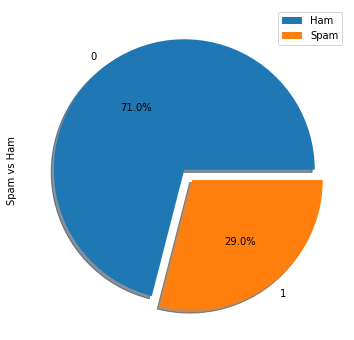

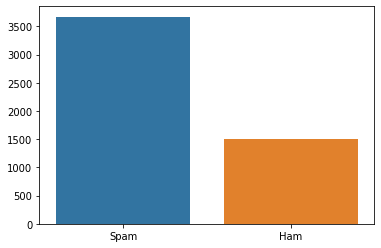

In [11]:
# Dropping rows with NA values
messages.dropna(inplace=True)

messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()
sns.barplot(x=['Spam','Ham'],y=[messages["category"].value_counts()[0],messages["category"].value_counts()[1]])

plt.show()

## A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

In [12]:
import nltk
#nltk.download('stopwords')
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# Tokenization of Spam and Ham into words
## Tokenization is the process by which big quantity of text is divided into smaller parts called tokens. Here word_tokenize is used for splitting the words

In [13]:
#import nltk
#nltk.download('punkt')
from nltk import word_tokenize

In [14]:

spam_messages = messages[messages["category"] == 1]["text"]
ham_messages = messages[messages["category"] == 0]["text"]
spam_words = []
ham_words = []

## in natural language processing certain things are needed to be done...
## like tokenizing the words(creating a list of words only) and lowercase the word
## removing the stopwords(words that donot give any info about the subject like the,is,of etc)
## lemitiztion and stemming the word to their root form i.e like working->work etc

In [15]:
 
def extractSpamWords(spamMessages):
    global spam_words, spam_exception_count
    spam_exception_count = 0
    try:
        word_tokenized = word_tokenize(spamMessages)
        words = [word.lower() for word in word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        spam_words = spam_words + words
    except:
        spam_exception_count += 1
        
def extractHamWords(hamMessages):
    global ham_words, ham_exception_count
    ham_exception_count = 0
    try:
        word_tokenized = word_tokenize(hamMessages)
        words = [word.lower() for word in  word_tokenized if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
        ham_words = ham_words + words
    except:
        ham_exception_count += 1
        
    
# Checking tokenization errors. At some point I had to troubleshoot the code
spam_messages.apply(extractSpamWords)
print('spam exception count: ', spam_exception_count)
ham_messages.apply(extractHamWords)
print('ham exception count: ', ham_exception_count)


spam exception count:  0
ham exception count:  0


## List of words retrieved

In [16]:
# print(spam_words)
# print(ham_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Using wordcloud for pictorial represntation of respective words list

In [17]:
# %pip install wordcloud
from wordcloud import WordCloud

## the ham mail usually conation some casual word lik think ,said ,peopl,mailing,make etc.....
## this observation can be easily made by seeing the wordcloud
## the word cloud shows the word that are most used with a larger font size

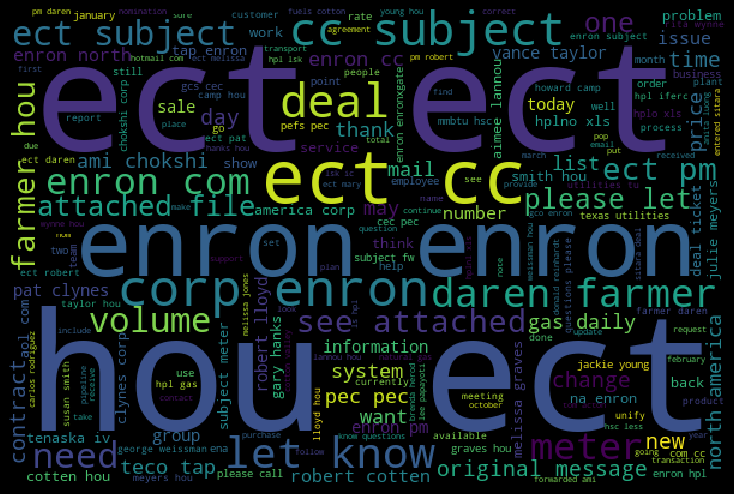

In [18]:
from wordcloud import WordCloud
ham_wordcloud=WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## in spam message their is a trend of using word like business ,mv,money mail etc

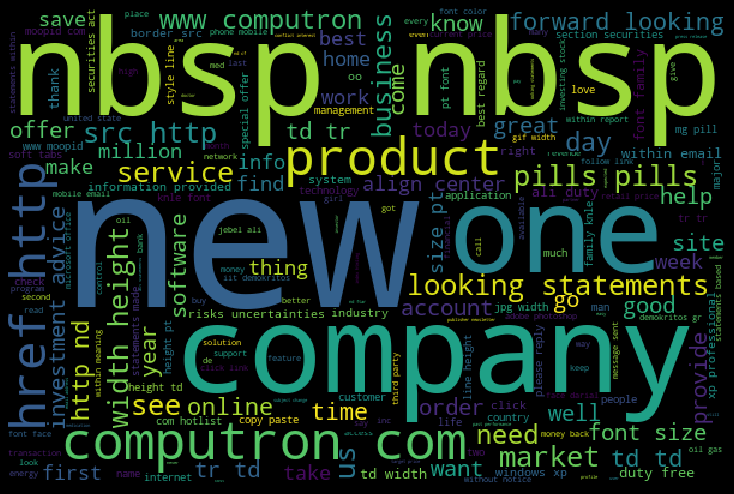

In [19]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Top 10 most occuring words in each list

## obvisouly their are certian words common to both ham and spam , but some words are only in ham or spam we can find out 
## the top word so that we can rely on those to bulid our ml clasiifcation model
## using all the words as our features will increase the complexity of mode as well as might overfit it casuing a 
## high training efficency but lower testing accuracy

In [20]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
sp_df=pd.Series(spam_words).value_counts().head(n = 10)
print(sp_df)
ham_words = np.array(ham_words)
print("\nTop 10 Ham words are :\n")
ha_df=pd.Series(ham_words).value_counts().head(n = 10)
print(ha_df)


Top 10 Spam words are :

com            991
http           983
company        726
e              613
www            587
information    513
font           511
td             504
statements     476
please         475
dtype: int64

Top 10 Ham words are :

ect        13893
hou         7281
enron       6279
subject     2728
please      2697
com         2693
deal        2655
gas         2629
cc          2357
pm          2325
dtype: int64


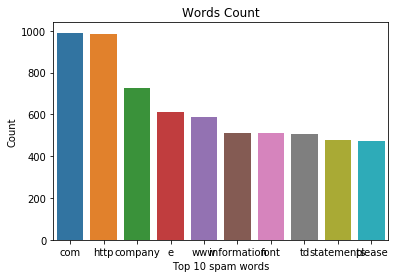

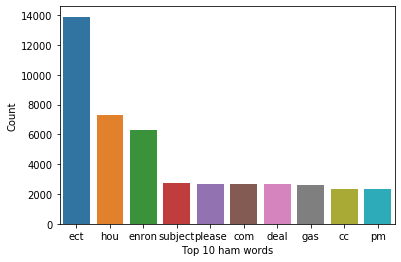

In [21]:
sns.barplot(x=sp_df.index,y=sp_df.values)
plt.xlabel('Top 10 spam words')
plt.ylabel("Count")
plt.title("Words Count")
plt.show()
sns.barplot(x=ha_df.index,y=ha_df.values)
plt.xlabel('Top 10 ham words')
plt.ylabel("Count")
plt.show()

## Description and analysis of the whole set

In [22]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count     5172.000000
mean       986.755607
std       1502.989698
min          0.000000
25%        200.000000
50%        486.000000
75%       1171.000000
max      31817.000000
Name: messageLength, dtype: float64

## Representation of different type of categories in the set with accordance to the number of their occurence in the set according to their category

In [23]:
## The distribution of length of spam male is usually normally distributed while the ham male lengths are quite random .
## this help us to build our classifer model if we can somehow able to find the average length of the spam mails

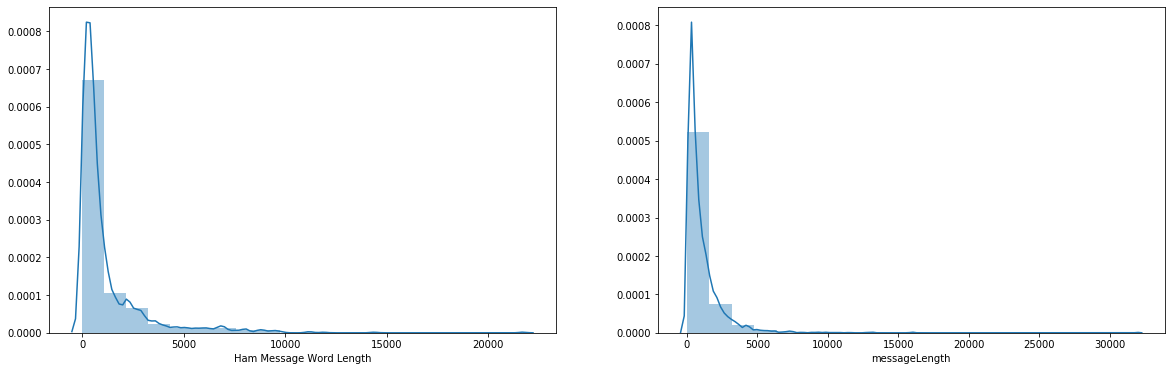

In [24]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == 1]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == 0]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

## Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

In [25]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    try:
        message = message.translate(str.maketrans('', '', string.punctuation))
        words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
        return " ".join(words)
    except:
        print(message)
        
    
messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    


,text,category,messageLength
0,,0,0
1,gari product high island larger block 1 2 comm...,0,4282
2,calpin daili gas nomin 1 doc,0,38
3,fyi see note alreadi done stella forward stell...,0,1171
4,fyi forward lauri allen hou ect 12 14 99 12 17...,0,1124
5,jacki sinc inlet 3 river plant shut 10 19 99 l...,0,534
6,georg need follow done jan 13 zero 012 27049 0...,0,411
7,fyi forward gari l payn hou ect 12 14 99 02 35...,0,1375
8,two field gas difficulti unifi system 1 cage r...,0,1616
9,thank much memo would like reiter support two ...,0,3039


In [26]:
##avergaelegth of mails
avg_ham=messages[messages['category']==0]
print('ham length->>',np.mean(avg_ham['messageLength']),"max ->>",np.max(avg_ham['messageLength']),"Min ->>",np.min(avg_ham['messageLength']))
avg_spam=messages[messages['category']==1]
print('spam length->>',np.mean(avg_spam['messageLength']),"max ->>",np.max(avg_spam['messageLength']),"Min ->>",np.min(avg_spam['messageLength']))


ham length->> 918.5152505446623 max ->> 31817 Min ->> 0
spam length->> 1153.808 max ->> 21705 Min ->> 0


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(5172, 41860)


## instead of maually spliting the dataset into testing and training we can use sklearn magic
## test train split function allow us to split the dataset into testing and training so that we can make sure that
## our model works well before we demploy them

In [28]:
from sklearn.model_selection import train_test_split
print(features.shape)
print(messages["category"].shape)
X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2)

(5172, 41860)
(5172,)


In [29]:
X_train

<4137x41860 sparse matrix of type '<class 'numpy.float64'>'
	with 254333 stored elements in Compressed Sparse Row format>

In [30]:
vec.get_feature_names()

['00',
 '000',
 '0000',
 '000000',
 '000000000002858',
 '000000000049773',
 '000080',
 '000099',
 '0001',
 '00018',
 '00020608',
 '0004',
 '0005',
 '0008',
 '001',
 '0010',
 '001001',
 '0012',
 '001452',
 '002',
 '0022',
 '00221',
 '0025',
 '0027',
 '0028',
 '0029',
 '00298',
 '003',
 '0030',
 '003002',
 '0031',
 '0033',
 '0038',
 '004',
 '0042',
 '0043',
 '0044',
 '0045',
 '0046',
 '0047',
 '0049',
 '005',
 '00501723',
 '0051',
 '00534580',
 '006',
 '006600',
 '0067',
 '007',
 '0071',
 '008',
 '0080',
 '009',
 '0090',
 '01',
 '010',
 '0100',
 '0101',
 '011',
 '0117',
 '012',
 '012603',
 '013',
 '0130',
 '014',
 '01408304990',
 '01474',
 '015',
 '016',
 '017',
 '0170',
 '01778',
 '0182',
 '0184',
 '019',
 '019017',
 '01915',
 '02',
 '020',
 '0200',
 '02010207',
 '021',
 '022',
 '0232',
 '024',
 '025',
 '0255',
 '025648',
 '026',
 '027',
 '028',
 '02886',
 '02897893',
 '029',
 '03',
 '030',
 '0300',
 '03090806',
 '031',
 '0310041',
 '03149',
 '032',
 '0324',
 '033',
 '0331',
 '034',
 '0

In [31]:
new_data=['high - quality affordable logos corporate image can say a lot of things about you']

In [32]:
a=vec.transform(new_data)
a

<1x41860 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

## the skleran module has lots of ml algorithms inbuilt only the necessary imports are to be made
## the sklearn module also provides different metrices to test our model for acuuracy

In [33]:
from sklearn.metrics import classification_report

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)
train_acc=[]
test_acc=[]
confusion_matt_list=[]
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\n" + name + ":")
    print("Training accuracy: {:.2f}%".format(100 * model.score(X_train,y_train)))
    test_acc.append(model.score(X_train,y_train))
    print("Testing accuracy: {:.2f}%".format(100 * model.score(X_test,y_test)))
    train_acc.append(model.score(X_test,y_test))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
    print("Confusion Matrix:\n")
    print(classification_report(y_test, y_pred))
    confusion_m = confusion_matrix(y_test, y_pred)
    confusion_matt_list.append(confusion_m)
    #sns.heatmap(confusion_m,annot=True)
    #plt.show()
    #df_cm = pd.DataFrame(confusion_m)
    #print(confusion_m)
    print('----------------------------------------------------------------------------------------------')


K Nearest Neighbors:
Training accuracy: 64.73%
Testing accuracy: 57.68%
Precision: 40.60%
Recall: 99.33%
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.99      0.41      0.58       735
           1       0.41      0.99      0.58       300

    accuracy                           0.58      1035
   macro avg       0.70      0.70      0.58      1035
weighted avg       0.82      0.58      0.58      1035

----------------------------------------------------------------------------------------------

Decision Tree:
Training accuracy: 99.81%
Testing accuracy: 94.69%
Precision: 90.16%
Recall: 91.67%
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       735
           1       0.90      0.92      0.91       300

    accuracy                           0.95      1035
   macro avg       0.93      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035

-------

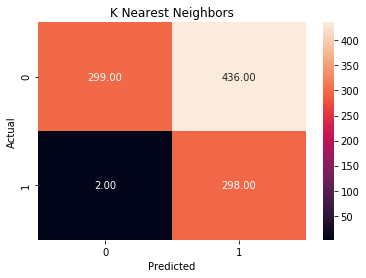

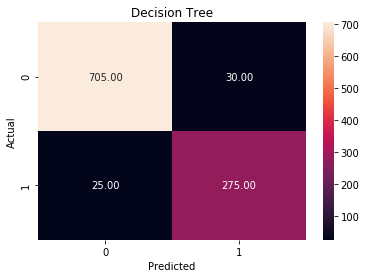

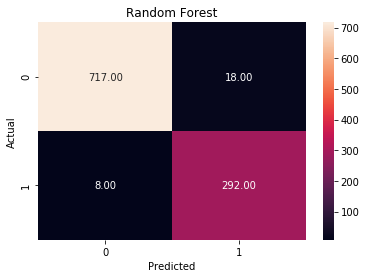

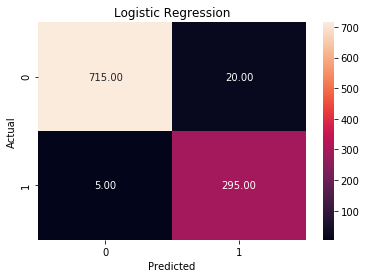

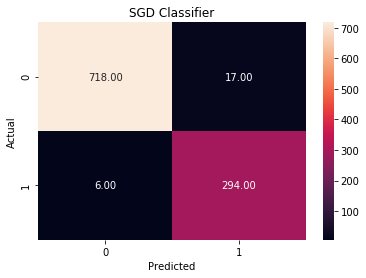

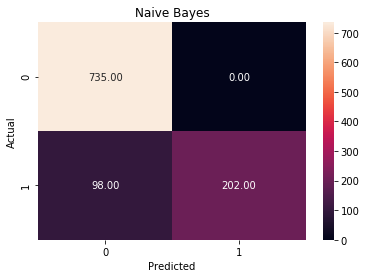

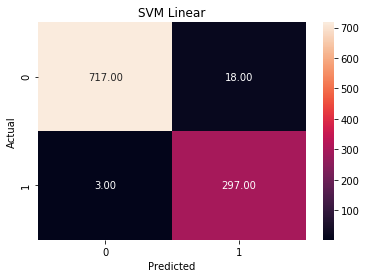

In [35]:
#confusion matrix
j=-1
for i in confusion_matt_list:
    j=j+1
    sns.heatmap(i,annot=True,fmt='.2f',xticklabels=['0','1'],yticklabels=['0','1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(names[j])
    plt.show()

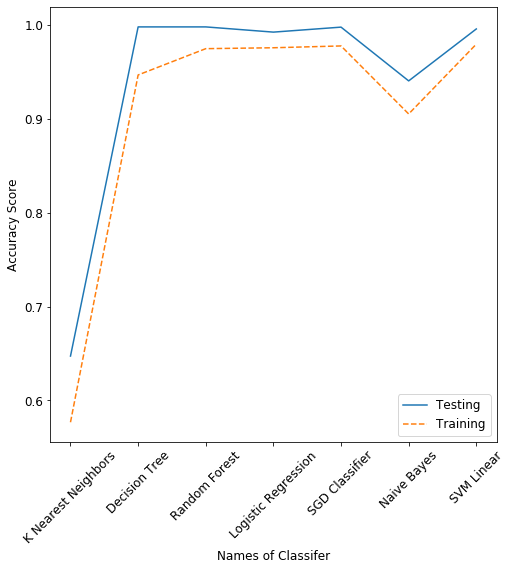

In [36]:
# Test accuracy comparison
matplotlib.rcParams.update({'font.size': 12})
plt.subplots(figsize=(8,8))
plt.plot(names,test_acc)
plt.plot(names,train_acc,'--')
plt.legend(['Testing','Training'])
plt.xlabel('Names of Classifer')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.show()


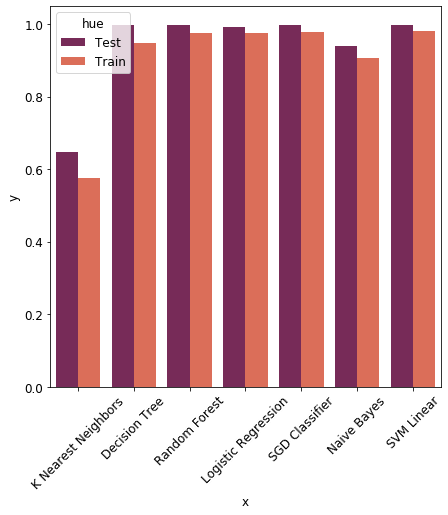

In [37]:
df1=pd.DataFrame({'x': names,'y': test_acc})
df2=pd.DataFrame({'x': names,'y': train_acc})
df1['hue']='Test'
df2['hue']='Train'
res=pd.concat([df1,df2])
plt.subplots(figsize=(7,7))
sns.barplot(x='x',y='y',data=res,hue='hue',palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [38]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\ASUS\anaconda3\python.exe -m pip install --upgrade pip' command.


In [39]:
from xgboost import XGBClassifier

In [40]:
xgbmodel=XGBClassifier()

xgbmodel.fit(X_train,y_train)
sbgpred=xgbmodel.predict(X_test)

In [41]:
print("Training accuracy: {:.2f}%".format(100 * xgbmodel.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * xgbmodel.score(X_test,y_test)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, sbgpred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, sbgpred)))
print(classification_report(y_test, sbgpred))
confusion_matrix(y_test, sbgpred)

Training accuracy: 99.25%
Testing accuracy: 96.71%
Precision: 92.90%
Recall: 96.00%
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       735
           1       0.93      0.96      0.94       300

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



array([[713,  22],
       [ 12, 288]], dtype=int64)

In [42]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
adamodel=AdaBoostClassifier(n_estimators=100)
adamodel.fit(X_train,y_train)
adapred=adamodel.predict(X_test)

In [43]:
print("Training accuracy: {:.2f}%".format(100 * adamodel.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * adamodel.score(X_test,y_test)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, adapred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, adapred)))
print(classification_report(y_test, adapred))
confusion_matrix(y_test, adapred)

Training accuracy: 99.06%
Testing accuracy: 95.75%
Precision: 92.95%
Recall: 92.33%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       735
           1       0.93      0.92      0.93       300

    accuracy                           0.96      1035
   macro avg       0.95      0.95      0.95      1035
weighted avg       0.96      0.96      0.96      1035



array([[714,  21],
       [ 23, 277]], dtype=int64)

In [44]:
bagmodel=BaggingClassifier()
bagmodel.fit(X_train,y_train)
bagpred=bagmodel.predict(X_test)

In [45]:
print("Training accuracy: {:.2f}%".format(100 * bagmodel.score(X_train,y_train)))
print("Testing accuracy: {:.2f}%".format(100 * bagmodel.score(X_test,y_test)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, bagpred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, bagpred)))
print(classification_report(y_test, bagpred))
confusion_matrix(y_test, bagpred)

Training accuracy: 99.40%
Testing accuracy: 95.36%
Precision: 90.91%
Recall: 93.33%
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       735
           1       0.91      0.93      0.92       300

    accuracy                           0.95      1035
   macro avg       0.94      0.95      0.94      1035
weighted avg       0.95      0.95      0.95      1035



array([[707,  28],
       [ 20, 280]], dtype=int64)

In [46]:
SVM=SVC(kernel = 'linear')

In [47]:
SVM.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
a=vec.transform(['''
as we discussed , this change was missed but was discussed with you
last week . i apologize for the omission . i am checking with my field
personnel and anticipate a further reduction ( due to well production
decreases ) effective 12 / 15 which i will send under a separate email for an
" intra - day " change wednesday .
here ' s revised december 1999 ( effective 12 / 9 / 99 ) setup for
josey : ( using 1 . 081 btu / mcf )
'''])
a

<1x41860 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [49]:
SVM.predict(a)

array([0], dtype=int64)

In [50]:
filename='model.pkl'

In [58]:
pickle.dump(SVM,open(filename, 'wb'))

In [52]:
def mailpredict(text):
    type(text)
    to_predict=[text]
    loaded_model = pickle.load(open('model.pkl','rb'))
    result = loaded_model.predict(vec.transform(to_predict))
    print(loaded_model)
    return result

In [53]:
pr='''as we discussed , this change was missed but was discussed with you
last week . i apologize for the omission . i am checking with my field
personnel and anticipate a further reduction ( due to well production
decreases ) effective 12 / 15 which i will send under a separate email for an
" intra - day " change wednesday .
here ' s revised december 1999 ( effective 12 / 9 / 99 ) setup for
josey : ( using 1 . 081 btu / mcf )'''

In [54]:
type(pr)

str

In [55]:
result = mailpredict(pr)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [56]:
result[0]

0

In [59]:
pickle.dump(vec,open('vec.pkl', 'wb'))

In [60]:
vec_mode = pickle.load(open('vec.pkl','rb'))
vec_mode

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='latin-1',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)